In [509]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as s

from tqdm import tqdm
from sympy import Integer as Int # see https://docs.sympy.org/latest/tutorial/gotchas.html#two-final-notes-and
from scipy.integrate import solve_ivp
from IPython.display import Video

In [510]:
# constants
m,g,l = s.symbols("m g \ell",positive=True) 
# not functions, act as varaibles
θ1,θ2,ω1,ω2 = s.symbols(r"\theta_1 \theta_2 \omega_1 \omega_2")
# functions, for differentiation of coordinates
Θ1,Θ2 = s.symbols(r"\Theta_1 \Theta_2",cls=s.Function) 
t = s.symbols("t")


m1 = m2 = m
l1 = l2 = l

In [511]:
# coordinates
x1 =  l1*s.sin(Θ1(t))
y1 = -l1*s.cos(Θ1(t))
x2 = x1+l2*s.sin(Θ2(t))
y2 = y1-l2*s.cos(Θ2(t))
# Inertia
I1 = m1*(x1**2+y1**2)
I2 = m2*(x2**2+y2**2)

In [512]:
# translational and rotational Kinetic energy
K = m1*(x1.diff(t)**2+y1.diff(t)**2)/Int(2) + I1*ω1**2/Int(2) + \
    m1*(x2.diff(t)**2+y2.diff(t)**2)/Int(2) + I2*ω2**2/Int(2)
# potential energy
U = m1*g*y1 + m2*g*y2

In [513]:
L = s.simplify((K-U).subs([
    [Θ1(t).diff(),ω1],
    [Θ2(t).diff(),ω2],
    [Θ1(t),θ1],
    [Θ2(t),θ2],
]))

In [514]:
# solve the velocities in terms of the momenta, and substitute to obrtain a lagrangian in phase space L(q,p)

p1,p2 = s.symbols("p1 p2")

sol = s.solve([
    s.Eq(p1, L.diff(ω1)),
    s.Eq(p2, L.diff(ω2))
],[ω1,ω2])

L = L.subs(sol)

$$
\mathcal{H} = \dot q_\mu p^\mu - \mathcal{L}
$$

In [515]:
H = sol[ω1]*p1+sol[ω2]*p2-L

$$
y = \{\theta_1,\theta_2,p_1,p_2\} \qquad \frac{dy}{dt} = f(t,y) 
$$

$$\frac{\mathrm{d}\boldsymbol{p}}{\mathrm{d}t} = -\frac{\partial \mathcal{H}}{\partial \boldsymbol{q}}\quad,\quad
\frac{\mathrm{d}\boldsymbol{q}}{\mathrm{d}t} = +\frac{\partial \mathcal{H}}{\partial \boldsymbol{p}}
$$

In [516]:
f = [H.diff(p1),H.diff(p2),-H.diff(θ1),-H.diff(θ2)]
#f = [*map(s.simplify,[H.diff(p1),H.diff(p2),-H.diff(θ1),-H.diff(θ2)])]

In [517]:
def make_F(m_,l_,g_=9.8):
    fn = s.Matrix([[*map(lambda _:_.subs({m:m_,l:l_,g:g_}),f)]])
    F = s.lambdify([t,(θ1,θ2,p1,p2)],fn,"numpy")
    return lambda t,y: F(t,y)[0]

In [522]:
%%time
ini = np.array([1,0.6,0,0])
σ = 0.1
N = 50 
tmax = 10
dt = 0.01

# several solutions with random normal deviations in the phase space
nsols = [solve_ivp(
    make_F(1,1),
    (0,10),
    ini+np.random.normal(scale=σ,size=4),
    t_eval=np.arange(0,tmax,dt)
) for _ in range(N)]

Ys = [nsol["y"] for nsol in nsols]

CPU times: user 17 s, sys: 27.8 ms, total: 17 s
Wall time: 17 s


In [523]:
x1s = [np.sin(Y[0]) for Y in Ys]
y1s = [-np.cos(Y[0]) for Y in Ys]
x2s = [np.sin(Y[0]) + np.sin(Y[1]) for Y in Ys]
y2s = [-np.cos(Y[0]) - np.cos(Y[1]) for Y in Ys]

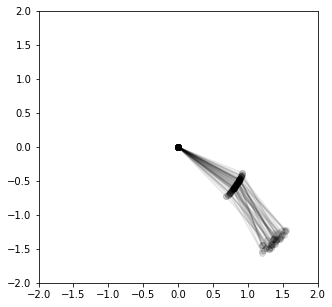

In [524]:
i=5
plt.figure(figsize=(5,5))
plt.xlim([-2,2])
plt.ylim([-2,2])
for j in range(N):
    plt.plot([0,x1s[j][i]],[0,y1s[j][i]],"ko-",alpha=0.1)
    plt.plot([x1s[j][i],x2s[j][i]],[y1s[j][i],y2s[j][i]],"ko-",alpha=0.1)

In [525]:
# remove existent images
!rm -f *.png

In [526]:
plt.figure(figsize=(10,10))

# Every frame is an image
for i in tqdm(range(len(Ys[0][0])),ncols=100):
    plt.xlim([-2,2])
    plt.ylim([-2,2])
    for j in range(N):
        plt.plot([0,x1s[j][i]],[0,y1s[j][i]],"ko-",alpha=0.1)
        plt.plot([x1s[j][i],x2s[j][i]],[y1s[j][i],y2s[j][i]],"ko-",alpha=0.15)
    plt.savefig(str(i).zfill(4)+".png")
    plt.clf()

100%|███████████████████████████████████████████████████████████| 1000/1000 [04:37<00:00,  3.61it/s]


<Figure size 720x720 with 0 Axes>

In [527]:
!ffmpeg -framerate 30 -pattern_type glob -i '*.png' -c:v libx264  out.mp4 -y

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

In [528]:
Video("out.mp4")

## How about triple pendulum?

In [533]:
m,g,l = s.symbols("m g \ell",positive=True)
θ1,θ2,θ3,ω1,ω2,ω3 = s.symbols(r"\theta_1 \theta_2 \theta_3 \omega_1 \omega_2 \omega_3")
Θ1,Θ2,Θ3 = s.symbols(r"\Theta_1 \Theta_2 \Theta_3",cls=s.Function) 
t = s.symbols("t")


m1 = m2 = m3 = m
l1 = l2 = l3 = l

# coordinates
x1 =  l1*s.sin(Θ1(t))
y1 = -l1*s.cos(Θ1(t))

x2 = x1+l2*s.sin(Θ2(t))
y2 = y1-l2*s.cos(Θ2(t))

x3 = x2+l3*s.sin(Θ3(t))
y3 = y2-l3*s.cos(Θ3(t))
# Inertia
I1 = m1*(x1**2+y1**2)
I2 = m2*(x2**2+y2**2)
I3 = m3*(x3**2+y3**2)

In [534]:
%%time
K = m1*(x1.diff(t)**2+y1.diff(t)**2)/Int(2) + I1*ω1**2/Int(2) + \
    m2*(x2.diff(t)**2+y2.diff(t)**2)/Int(2) + I2*ω2**2/Int(2) + \
    m3*(x3.diff(t)**2+y3.diff(t)**2)/Int(2) + I3*ω3**2/Int(2)

U = m1*g*y1 + m2*g*y2 + m3*g*y3

L = s.simplify((K-U).subs([
    [Θ1(t).diff(),ω1],
    [Θ2(t).diff(),ω2],
    [Θ3(t).diff(),ω3],
    [Θ1(t),θ1],
    [Θ2(t),θ2],
    [Θ3(t),θ3],
]))

p1,p2,p3 = s.symbols("p1 p2 p3")

sol = s.solve([
    s.Eq(p1, L.diff(ω1)),
    s.Eq(p2, L.diff(ω2)),
    s.Eq(p3, L.diff(ω3))
],[ω1,ω2,ω3])

L = L.subs(sol)

In [553]:
H = sol[ω1]*p1+sol[ω2]*p2+sol[ω3]*p3-L

In [554]:
f = [H.diff(p1),H.diff(p2),H.diff(p3),-H.diff(θ1),-H.diff(θ2),-H.diff(θ3)]

In [555]:
def make_F(m_,l_,g_=9.8):
    fn = s.Matrix([[*map(lambda _:_.subs({m:m_,l:l_,g:g_}),f)]])
    F = s.lambdify([t,(θ1,θ2,θ3,p1,p2,p3)],fn,"numpy")
    return lambda t,y: F(t,y)[0]

In [556]:
%%time
ini = np.array([np.pi,np.pi,np.pi,0,0,0])*0.4
σ = 0.05
N = 10
tmax = 5
dt = 0.01

# several solutions with random normal deviations in the phase space
nsols = [solve_ivp(
    make_F(1,1),
    (0,tmax),
    ini+np.random.normal(scale=σ,size=6),
    t_eval=np.arange(0,tmax,dt)
) for _ in range(N)]

Ys = [nsol["y"] for nsol in nsols]

CPU times: user 1min 14s, sys: 42.5 ms, total: 1min 14s
Wall time: 1min 14s


In [557]:
x1s = [np.sin(Y[0]) for Y in Ys]
y1s = [-np.cos(Y[0]) for Y in Ys]
x2s = [np.sin(Y[0]) + np.sin(Y[1]) for Y in Ys]
y2s = [-np.cos(Y[0]) - np.cos(Y[1]) for Y in Ys]
x3s = [np.sin(Y[0]) + np.sin(Y[1]) + np.sin(Y[2]) for Y in Ys]
y3s = [-np.cos(Y[0]) - np.cos(Y[1]) - np.cos(Y[2]) for Y in Ys]

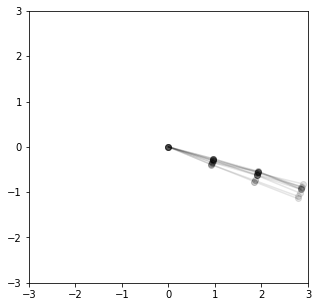

In [558]:
i=5
plt.figure(figsize=(5,5))
plt.xlim([-3,3])
plt.ylim([-3,3])
for j in range(N):
    plt.plot([0,x1s[j][i]],[0,y1s[j][i]],"ko-",alpha=0.1)
    plt.plot([x1s[j][i],x2s[j][i]],[y1s[j][i],y2s[j][i]],"ko-",alpha=0.1)
    plt.plot([x2s[j][i],x3s[j][i]],[y2s[j][i],y3s[j][i]],"ko-",alpha=0.1)

In [559]:
!rm -f *.png

In [560]:
plt.figure(figsize=(10,10))

# Every frame is an image
for i in tqdm(range(len(Ys[0][0])),ncols=100):
    plt.xlim([-3,3])
    plt.ylim([-3,3])
    for j in range(N):
        plt.plot([0,x1s[j][i]],[0,y1s[j][i]],"ko-",alpha=0.1)
        plt.plot([x1s[j][i],x2s[j][i]],[y1s[j][i],y2s[j][i]],"ko-",alpha=0.15)
        plt.plot([x2s[j][i],x3s[j][i]],[y2s[j][i],y3s[j][i]],"ko-",alpha=0.2)
    plt.savefig(str(i).zfill(4)+".png")
    plt.clf()

100%|█████████████████████████████████████████████████████████████| 500/500 [01:25<00:00,  5.86it/s]


<Figure size 720x720 with 0 Axes>

In [561]:
!ffmpeg -framerate 30 -pattern_type glob -i '*.png' -c:v libx264  out3.mp4 -y

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

In [562]:
Video("out3.mp4")